# Principal Component Analysis

In this notebook...
- Use PCA for dimensionality reduction on a dataset with a large feature space
- Use PCA on an image dataset and visualize principal components as images in feature space
- Reconstruct images using principal components
- Use PCA to determine principal components of genotypic data

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.decomposition import PCA

# PCA for Dimensionality Reduction for Image Classification

PCA isn't very useful for classification on its own. But for big data, it is extremely useful as a dimension-reducer prior to classification.

This example is also based off that detailed in https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Here we'll use PCA on an image dataset. The original dataset has 2914 features (2914 pixels in each image). Principal comopnents will be linear combinations of pixels

### Load and Visualize Data
Plot some example images in feature space (the original data)

Current feature space is  2914  dimensions


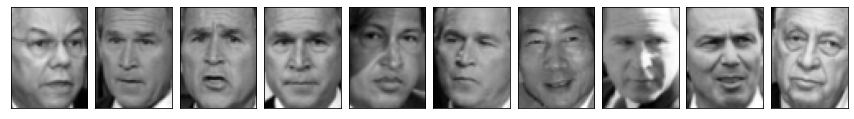

In [2]:
# load dataset available with sklearn download
from sklearn.datasets import fetch_lfw_people;
faces = fetch_lfw_people(min_faces_per_person=60)
print("Current feature space is ",faces.images.shape[1]*faces.images.shape[2]," dimensions")

# Visualize faces
fig,ax = plt.subplots(1,10,figsize=(15,3.0),
                         subplot_kw={'xticks':[],'yticks':[]},
                          gridspec_kw=dict(hspace=0.1,wspace=0.1))
for i in range(10):
    ax[i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')

### Run PCA and Visualize Components
Plot the first 24 principal components in feature space - each image is a different principal component

These images are analogous to vectors plotted in 2 dimensions when there are only 2 features. Now there are 2914 features, and the shade of each pixel corresponds to the weight of that feature in a given principal component.

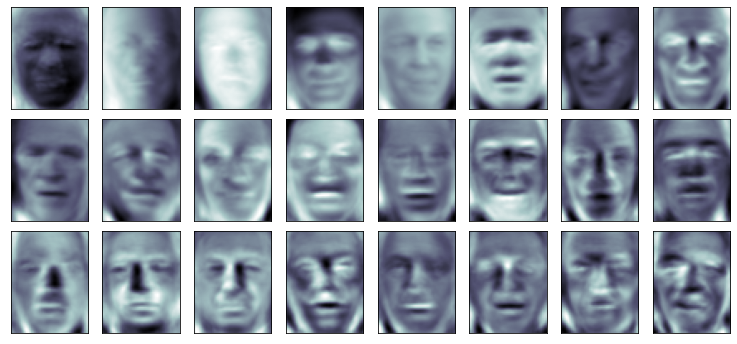

In [3]:
# run PCA
pca = PCA(150)
pca.fit(faces.data)

# Visualize components in feature space
fig, axes = plt.subplots(3, 8, figsize=(13, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

We can see here that PCA is an unsupervised method - some of these components, though they explain a lot of the variance between the images, would not be useful in image classification.

### Visualize Explained Variance

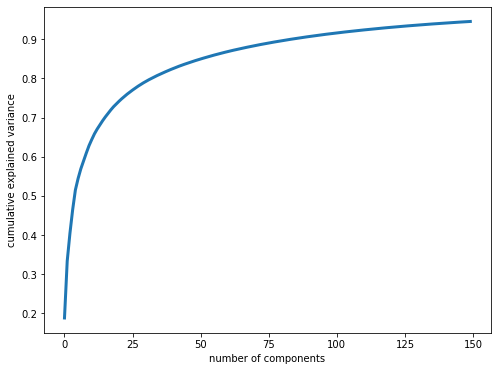

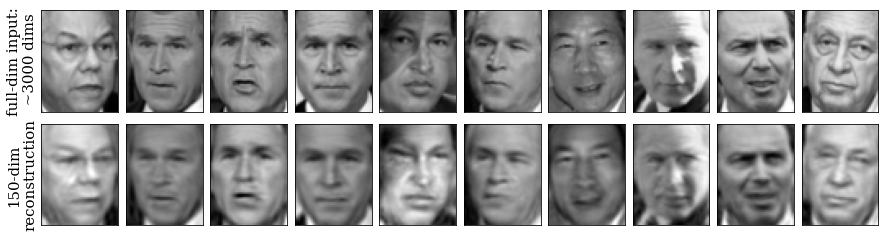

In [4]:
# visualize amount of variance explained by each component
fig,ax = plt.subplots(figsize=(8,6))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax.plot(np.cumsum(pca.explained_variance_ratio_),lw=3)
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');

# transform data into limited component space
components = pca.transform(faces.data)
# project transformed data onto limited feature space
projected = pca.inverse_transform(components)

# Visualize images in feature space with first 150 components
fig, ax = plt.subplots(2, 10, figsize=(15,4),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim input:\n ~3000 dims',fontsize=15)
ax[1, 0].set_ylabel('150-dim\nreconstruction',fontsize=15);

The above plot shows that over 90% of the variance can be explained by only 150 components. Recall that the original number of covariates was nearly 3000.

The images show reconstructions in feature space using the first 150 principal components, created by projecting each image into component space (which is 150 dimensions) and then back to feature space. If the images were reconstructed using all of the principal components, tranformation would return the original images.

With PCA, we reduced the dimensionality of this dataset by nearly 95%, and now classification 
can be performed on this dataset with much less computational power

# Bioengineering Example: Using PCA to classify bladder cells as cancerous or normal
This will be the dataset explored in this week's homework

Example from https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwitipaAs-_uAhWnFTQIHQ6tAwMQFjAAegQIBRAC&url=https%3A%2F%2Fphysiology.med.cornell.edu%2Fpeople%2Fbanfelder%2Fqbio%2Flecture_notes%2F3.4_Principal_component_analysis.pdf&usg=AOvVaw28yTFYFOswuMt4LAEXV-6U

citation: Leek JT (2020). bladderbatch: Bladder gene expression data illustrating batch effects. R package version 1.28.0.

### Load Data

We have data from 57 cells. From each cell, we know their phenotype (Normal, Cancerous, or Biopsy) and their genotype -- the expression of each of about 20000 genes. We want to use the genotypes to predict the phenotypes of the cells.

This would take intensive computational power, depending on the classification method. We can use PCA to reduce the feature space and to determine the genes most predictive of cancer

In [5]:
# import phenotype data
pdata = pd.read_csv("./data/pdata.csv")
print('Phenotype data: Cancer labels')
print(pdata.head())
print('\n')

# import expression data
edata = pd.read_csv("./data/edata.csv")
print('Expression data for over 20000 genes for each of 57 cells')
print(edata.iloc[:5,:5])

Phenotype data: Cancer labels
     Unnamed: 0  sample outcome  batch  cancer
0  GSM71019.CEL       1  Normal      3  Normal
1  GSM71020.CEL       2  Normal      2  Normal
2  GSM71021.CEL       3  Normal      2  Normal
3  GSM71022.CEL       4  Normal      3  Normal
4  GSM71023.CEL       5  Normal      3  Normal


Expression data for over 20000 genes for each of 57 cells
  Unnamed: 0  GSM71019.CEL  GSM71020.CEL  GSM71021.CEL  GSM71022.CEL
0  1007_s_at     10.115170      8.628044      8.779235      9.248569
1    1053_at      5.345168      5.063598      5.113116      5.179410
2     117_at      6.348024      6.663625      6.465892      6.116422
3     121_at      8.901739      9.439977      9.540738      9.254368
4  1255_g_at      3.967672      4.466027      4.144885      4.189338


### Visualize Data

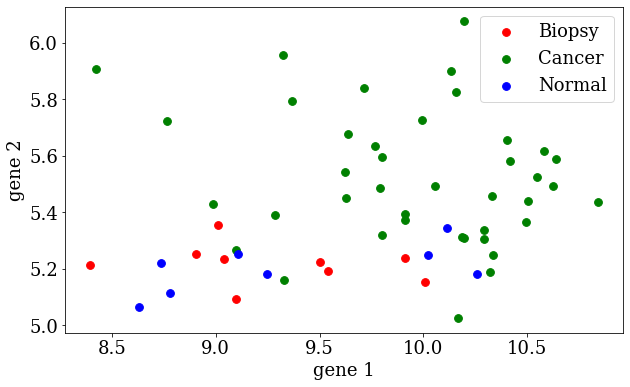

In [6]:
label = np.array(pdata.loc[:,'cancer']) #set phenotype as labels
cdict = {'Normal':'b','Biopsy':'r','Cancer':'g'} #plot data with color corresponding to phenotype

# plot gene expression data of first 2 genes
fig,ax=plt.subplots(figsize=(10,6))
plt.rc('font', **font)
for l in np.unique(label):
    ix = np.where(label==l) #plot each diagnosis as different color
    for i in ix:
        ax.scatter(edata.iloc[0,i+1],edata.iloc[1,i+1],60,c=cdict[l],label=l)
ax.legend()
ax.set_xlabel('gene 1')
ax.set_ylabel('gene 2')
plt.show()

### Demean Data and Perform PCA

In [7]:
# extract genotype data to perform PCA on
pcadata = np.swapaxes(np.array(edata.iloc[:,1:]),0,1)
pcadata = pcadata-np.mean(pcadata,axis=0) #demean data
# peform PCA
pca = PCA()
pca.fit(pcadata)
# transform data into component space
data_c = pca.transform(pcadata)

### Visualize Components

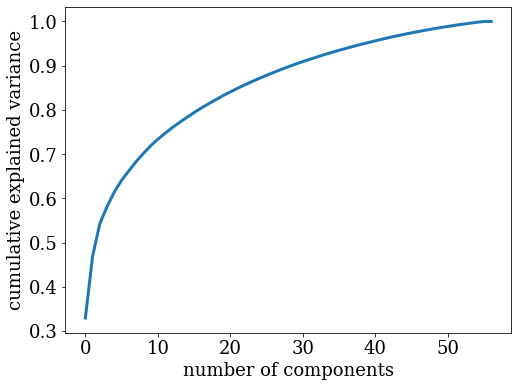

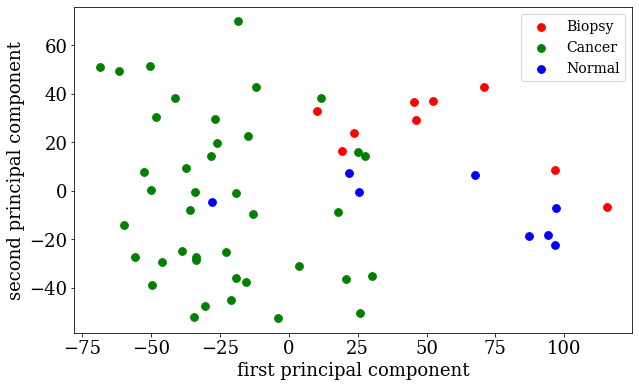

In [8]:
# plot explained variance
fig,ax = plt.subplots(figsize=(8,6))
plt.rc('font', **font)
ax.plot(np.cumsum(pca.explained_variance_ratio_),lw=3)
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');
ax.tick_params(axis='both')

# plot data in component space
fig,ax=plt.subplots(figsize=(10,6))
plt.rc('font', **font)
for l in np.unique(label):
    ix = np.where(label==l)
    for i in ix:
        ax.scatter(data_c[ix,0],data_c[ix,1],60,c=cdict[l],label=l)
ax.legend(fontsize=14)
ax.set_xlabel('first principal component')
ax.set_ylabel('second principal component')
plt.show()

Even projection onto just the first two principal components shows some separation between our 3 classes.

Classification with k means clustering, for example, in the space of just the first 2 components would have decent accuracy